# Assignment 2
## Applying Windy GridWorld
1.  Compare all solutions in terms of the optimal policies and episodes necessary for convergence. Select the best values for epsilon and alpha for each case. If they are different, discuss why.

2.  Re-solve the windy gridworld task with King’s moves, assuming that the effect of the wind, if there is any, is stochastic, sometimes varying by 1 from the mean values given for each column. That is, a third of the time you move exactly according to these values, as in the previous exercise, but also a third of the time you move one cell above that, and another third of the time you move one cell below that.

For example, if the agent is one cell to the right of the goal and it chooses to move left, then one-third of the time the agent will move one cell above the goal, one-third of the time you move two cells above the goal, and one-third of the time you move to the goal. YOU SHOULD ONLY USE THIS APPROACH.

## Import Documents and Libiraries

In [1]:
! pip install -q gym[all]
! git clone https://github.com/ibrahim-elshar/gym-windy-gridworlds.git
! pip install -q git+https://github.com/ibrahim-elshar/gym-windy-gridworlds.git

  ERROR: Failed building wheel for mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-dsj6_b64/mujoco-py_b89cae5c06e1492baeb6a92b9d0e0fa2/setup.py'"'"'; __file__='"'"'/tmp/pip-install-dsj6_b64/mujoco-py_b89cae5c06e1492baeb6a92b9d0e0fa2/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-cvymm1h2/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/mujoco-py Check the logs for full command output.
fatal: destination path 'gym-windy-gridworlds' already exists and is not an empty directory.


In [2]:
import gym
import gym_windy_gridworlds
from collections import defaultdict
import random
import math
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

## Q-Learning Function

In [3]:
class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
    # Returns Q(state,action)
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
     # Sets the Qvalue for [state,action] to the given value
        self._qvalues[state][action] = value

    def get_value(self, state):
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0
        value = max([self.get_qvalue(state,action) for action in possible_actions])
        return value

    def update(self, state, action, reward, next_state):
        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha
        target = reward+gamma*self.get_value(next_state)
        qvalue = learning_rate*target+(1-learning_rate)*self.get_qvalue(state,action)
        self.set_qvalue(state, action, qvalue )

    def get_best_action(self, state):
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None
        action_value_dict = {action: self.get_qvalue(state, action) for action in possible_actions}
        best_action = sorted(action_value_dict, key=lambda x:action_value_dict[x], reverse=True)[0]        
        return best_action

    def get_action(self, state):
        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None
        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None
        # agent parameters:
        epsilon = self.epsilon
        exploration = random.random()
        if exploration<epsilon:
            chosen_action = np.random.choice(possible_actions)
        else:
            chosen_action = self.get_best_action(state)

        return chosen_action

## SARSA Function

In [4]:
class SarsaAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
    # Returns Q(state,action)
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
     # Sets the Qvalue for [state,action] to the given value
        self._qvalues[state][action] = value


    def get_value(self, state):
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0
        state_value = self.get_qvalue(state,self.get_action(state))
        return state_value

    def update(self, state, action, reward, next_state):
        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha
        target = reward+gamma*self.get_value(next_state)
        qvalue = learning_rate*target+(1-learning_rate)*self.get_qvalue(state,action)
        self.set_qvalue(state, action, qvalue )

    def get_best_action(self, state):
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None
        action_value_dict = {action: self.get_qvalue(state, action) for action in possible_actions}
        best_action = sorted(action_value_dict, key=lambda x:action_value_dict[x], reverse=True)[0]        
        return best_action

    def get_action(self, state):
        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None
        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None
        # agent parameters:
        epsilon = self.epsilon
        exploration = random.random()
        if exploration<epsilon:
            chosen_action = np.random.choice(possible_actions)
        else:
            chosen_action = self.get_best_action(state)

        return chosen_action

## Train And Display Performance Functions

In [5]:
def play_and_train(env, agent, t_max=10**3):
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)
        next_s, r, done, _ = env.step(a)
        # train (update) agent for state s
        agent.update(s, a, r, next_s)
        s = next_s
        total_reward += r
        if done:
            break
    return total_reward

In [6]:
def reward_performance_perepisode(env,alpha,epsilon,qfunction):
    env=env
    n_actions = env.action_space.n
    env.reset()
    no=[]
    done = False
    while not done:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        no.append(+1)
    agent = qfunction(alpha=alpha, epsilon=epsilon, discount=1,
                       get_legal_actions=lambda s: range(n_actions))
    
    reward =[]
    for i in range(301):
        reward.append(play_and_train(env, agent))
        agent.epsilon *= 1

        if i % 100 == 0:
            clear_output(True)
            print('∈ =', agent.epsilon,', α =',agent.alpha, ', mean reward =', np.mean(reward[-10:]))
            # print('reward =', reward[-1])
            plt.plot(reward)
            plt.show()

In [7]:
def path(env):
    for i_episode in range(1):
        observation = env.reset()
        for t in range(6000):
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            env.render()
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break


## Windy Gridword


### With QLearning


In [8]:
### 0.5 alpha, 0.5 epsilon
reward_performance_perepisode(env=gym.make('WindyGridWorld-v0'),alpha=0.5,epsilon=0.5,qfunction=QLearningAgent)

∈ = 0.5 , α = 0.5 , mean reward = -33.5


In [9]:
path(env=gym.make('WindyGridWorld-v0'))

############
#          #
#          #
#X         #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#X         #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#X         #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#X         #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#X         #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#X         #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#X         #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#X         #
#          #
#S  

∈ = 0.1 , α = 0.5 , mean reward = -16.6


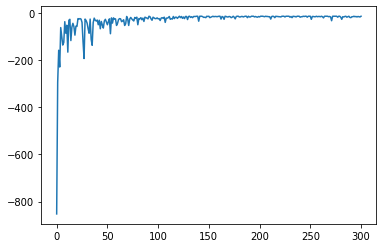

In [10]:
### 0.5 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('WindyGridWorld-v0'),alpha=0.5,epsilon=0.1,qfunction=QLearningAgent)

In [11]:
path(env=gym.make('WindyGridWorld-v0'))

############
#          #
#          #
#          #
#X      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#SX     G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
# X        #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#X         #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#X         #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#          #
#X         #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#          #
#X         #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#          #
# X        #
############

############
#          #
#          #
#          #
#S  

In [12]:
### 0.25 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('WindyGridWorld-v0'),alpha=0.25,epsilon=0.1,qfunction=QLearningAgent)

∈ = 0.1 , α = 0.25 , mean reward = -17.8


In [13]:
path(env=gym.make('WindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
############
# X        #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
# X        #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#  X       #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

#####

### With SARSA


∈ = 0.25 , α = 0.5 , mean reward = -30.2


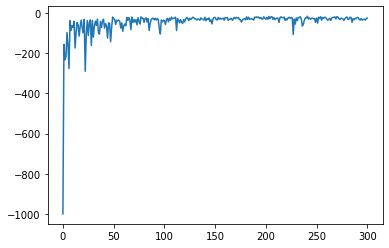

In [14]:
### 0.5 alpha, 0.25 epsilon
reward_performance_perepisode(env=gym.make('WindyGridWorld-v0'),alpha=0.5,epsilon=0.25,qfunction=SarsaAgent)

In [15]:
path(env=gym.make('WindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
#          #
#          #
#          #
#SX     G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#X      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#SX     G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
# X        #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#  X       #
#          #
#          #
############

############
#          #
#          #
#          #
#S X    G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#SX     G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#S X    G  #
#          #
#          #
#          #
############

############
#    

∈ = 0.1 , α = 0.5 , mean reward = -18.8


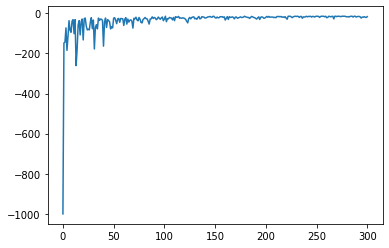

In [16]:
### 0.5 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('WindyGridWorld-v0'),alpha=0.5,epsilon=0.1,qfunction=SarsaAgent)

In [17]:
path(env=gym.make('WindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#        X #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#         X#
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#         X#
#          #
#S      G  #
#          #
#          #
#          #
############

############
#         X#
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#         X#
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#    

∈ = 0.1 , α = 0.1 , mean reward = -39.4


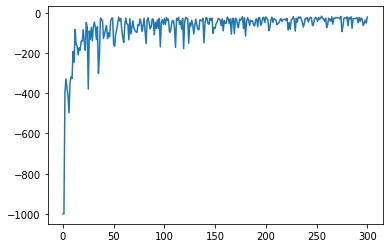

In [18]:
### 0.1 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('WindyGridWorld-v0'),alpha=0.1,epsilon=0.1,qfunction=SarsaAgent)

In [19]:
path(env=gym.make('WindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
#      X   #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#      X   #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#     X    #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#     X    #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#    X     #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#    X     #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#   X      #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#  X       #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#   X

∈ = 0.1 , α = 0.25 , mean reward = -17.9


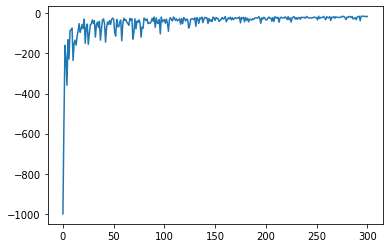

In [20]:
### 0.25 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('WindyGridWorld-v0'),alpha=0.25,epsilon=0.1,qfunction=SarsaAgent)

In [21]:
path(env=gym.make('WindyGridWorld-v0'))

############
#          #
#          #
#X         #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#X         #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
# X        #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#X         #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#X         #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#X      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#X         #
#          #
#          #
############

############
#          #
#          #
#          #
#X      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#X         #
#S  

∈ = 0.05 , α = 0.2 , mean reward = -21.5


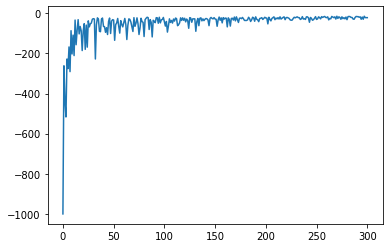

In [22]:
### 0.2 alpha, 0.05 epsilon
reward_performance_perepisode(env=gym.make('WindyGridWorld-v0'),alpha=0.2,epsilon=0.05,qfunction=SarsaAgent)

In [23]:
path(env=gym.make('WindyGridWorld-v0'))

############
#          #
#          #
#X         #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#X      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#X      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#X         #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#X         #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#X         #
#          #
#          #
############

############
#          #
#          #
#          #
#X      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#X         #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
# X        #
#S  

## Stochastic Windy Gridworld

### With Qlearning


In [24]:
# 0.5 alpha, 0.25 epsilon
reward_performance_perepisode(env=gym.make('StochWindyGridWorld-v0'),alpha=0.5,epsilon=0.25,qfunction=QLearningAgent)

∈ = 0.25 , α = 0.5 , mean reward = -85.0


In [25]:
path(env=gym.make('StochWindyGridWorld-v0'))

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  2  2  2  3  3  2  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  1  1  1  2  2  1  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
0  0  0  3  3  3  4  4  3  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
0  0  0  2  2  2  3  3  2  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o

In [26]:
# 0.5 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('StochWindyGridWorld-v0'),alpha=0.5,epsilon=0.1,qfunction=QLearningAgent)

∈ = 0.1 , α = 0.5 , mean reward = -47.3


In [27]:
path(env=gym.make('StochWindyGridWorld-v0'))

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  -1  -1  -1  0  0  -1  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  0  0  0  1  1  0  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  -1  -1  -1  0  0  -1  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  1  1  1  2  2  1  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o 

In [28]:
# 0.25 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('StochWindyGridWorld-v0'),alpha=0.25,epsilon=0.1,qfunction=QLearningAgent)

∈ = 0.1 , α = 0.25 , mean reward = -27.1


In [29]:
path(env=gym.make('StochWindyGridWorld-v0'))

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  2  2  2  3  3  2  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  3  3  3  4  4  3  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  -1  -1  -1  0  0  -1  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  -1  -1  -1  0  0  -1  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o 

### With SARSA


∈ = 0.1 , α = 0.5 , mean reward = -33.5


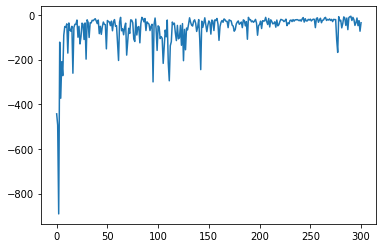

In [30]:
# 0.5 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('StochWindyGridWorld-v0'),alpha=0.5,epsilon=0.1,qfunction=SarsaAgent)

In [31]:
path(env=gym.make('StochWindyGridWorld-v0'))

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  -1  -1  -1  0  0  -1  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  0  0  0  1  1  0  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  -1  -1  -1  0  0  -1  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  -1  -1  -1  0  0  -1  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  

In [32]:
# 0.5 alpha, 0.25 epsilon
reward_performance_perepisode(env=gym.make('StochWindyGridWorld-v0'),alpha=0.5,epsilon=0.25,qfunction=SarsaAgent)

∈ = 0.25 , α = 0.5 , mean reward = -49.9


In [33]:
path(env=gym.make('StochWindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  3  3  3  4  4  3  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  0  0  0  1  1  0  0

o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  3  3  3  4  4  3  0

o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  1  1  1  2  2  1  0

o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o 

In [34]:
# 0.1 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('StochWindyGridWorld-v0'),alpha=0.1,epsilon=0.1,qfunction=SarsaAgent)

∈ = 0.1 , α = 0.1 , mean reward = -36.3


In [35]:
path(env=gym.make('StochWindyGridWorld-v0'))

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  3  3  3  4  4  3  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  2  2  2  3  3  2  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  3  3  3  4  4  3  0

o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  3  3  3  4  4  3  0

o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o

In [36]:
# 0.25 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('StochWindyGridWorld-v0'),alpha=0.25,epsilon=0.1,qfunction=SarsaAgent)

∈ = 0.1 , α = 0.25 , mean reward = -41.6


In [37]:
path(env=gym.make('StochWindyGridWorld-v0'))

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  -1  -1  -1  0  0  -1  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  1  1  1  2  2  1  0

o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  -1  -1  -1  0  0  -1  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  -1  -1  -1  0  0  -1  0

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  

In [38]:
### 0.2 alpha, 0.05 epsilon
reward_performance_perepisode(env=gym.make('StochWindyGridWorld-v0'),alpha=0.2,epsilon=0.05,qfunction=SarsaAgent)

∈ = 0.05 , α = 0.2 , mean reward = -30.4


In [39]:
path(env=gym.make('StochWindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  2  2  2  3  3  2  0

o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  0  0  0  1  1  0  0

o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  2  2  2  3  3  2  0

o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
0  0  0  3  3  3  4  4  3  0

o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o 

## King Windy Gridworld

### With QLearning


In [40]:
# 0.5 alpha, 0.25 epsilon
reward_performance_perepisode(env=gym.make('KingWindyGridWorld-v0'),alpha=0.5,epsilon=0.25,qfunction=QLearningAgent)

∈ = 0.25 , α = 0.5 , mean reward = -10.8


In [41]:
path(env=gym.make('KingWindyGridWorld-v0'))

############
#          #
#          #
#          #
#S      G  #
#X         #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
# X        #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#X         #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
# X        #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#X         #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#X         #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#          #
# X        #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#  X       #
#          #
############

############
#          #
#          #
#          #
#S  

∈ = 0.1 , α = 0.5 , mean reward = -10.1


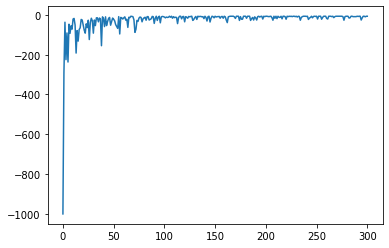

In [42]:
# 0.5 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('KingWindyGridWorld-v0'),alpha=0.5,epsilon=0.1,qfunction=QLearningAgent)

In [43]:
path(env=gym.make('KingWindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
#  X       #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#   X      #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#    X     #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#     X    #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#      X   #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#     X    #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#     X    #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#     X    #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#    

∈ = 0.1 , α = 0.25 , mean reward = -9.0


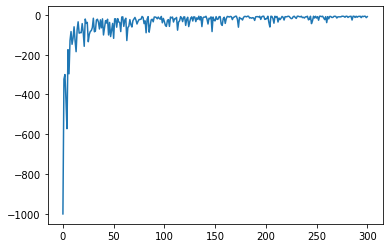

In [44]:
# 0.25 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('KingWindyGridWorld-v0'),alpha=0.25,epsilon=0.1,qfunction=QLearningAgent)

In [45]:
path(env=gym.make('KingWindyGridWorld-v0'))

############
#          #
#          #
#          #
#S      G  #
#X         #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
# X        #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#X         #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
# X        #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#X         #
#          #
############

############
#          #
#          #
#          #
#S      G  #
# X        #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#X         #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#          #
#X         #
############

############
#          #
#          #
#          #
#S  

### With SARSA


∈ = 0.1 , α = 0.1 , mean reward = -21.4


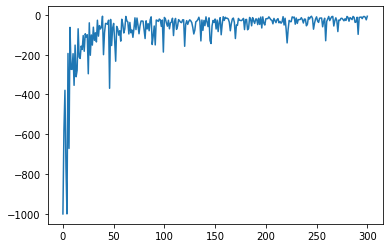

In [46]:
# 0.1 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('KingWindyGridWorld-v0'),alpha=0.1,epsilon=0.1,qfunction=SarsaAgent)

In [47]:
path(env=gym.make('KingWindyGridWorld-v0'))

############
#          #
#          #
# X        #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#S X    G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
# X        #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#X         #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#X         #
#          #
############

############
#          #
#          #
#          #
#S      G  #
# X        #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
# X        #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#X         #
#          #
############

############
#          #
#          #
#          #
#S  

∈ = 0.25 , α = 0.5 , mean reward = -23.2


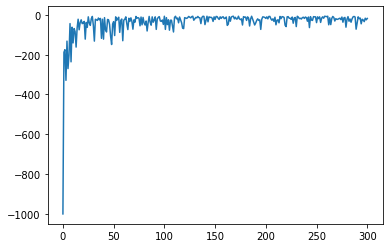

In [48]:
# 0.5 alpha, 0.25 epsilon
reward_performance_perepisode(env=gym.make('KingWindyGridWorld-v0'),alpha=0.5,epsilon=0.25,qfunction=SarsaAgent)

In [49]:
path(env=gym.make('KingWindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
#     X    #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#      X   #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#      X   #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#      X   #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#      X   #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#    

∈ = 0.1 , α = 0.5 , mean reward = -10.5


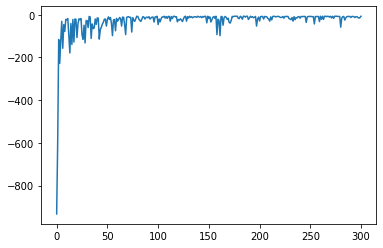

In [50]:
# 0.5 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('KingWindyGridWorld-v0'),alpha=0.5,epsilon=0.1,qfunction=SarsaAgent)

In [51]:
path(env=gym.make('KingWindyGridWorld-v0'))

############
#          #
#          #
# X        #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#SX     G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#S X    G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#SX     G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#X         #
#          #
#          #
############

############
#          #
#          #
#          #
#X      G  #
#          #
#          #
#          #
############

############
#          #
#          #
# X        #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#S X    G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#S  

∈ = 0.1 , α = 0.25 , mean reward = -12.0


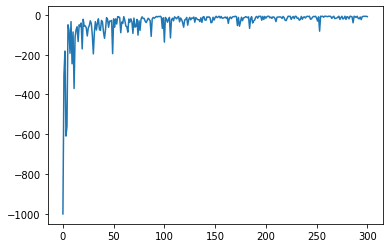

In [52]:
# 0.25 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('KingWindyGridWorld-v0'),alpha=0.25,epsilon=0.1,qfunction=SarsaAgent)

In [53]:
path(env=gym.make('KingWindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
#        X #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#        X #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#         X#
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#         X#
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#         X#
#S      G  #
#          #
#          #
#          #
############

############
#          #
#         X#
#          #
#S      G  #
#          #
#          #
#          #
############

############
#         X#
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#    

∈ = 0.05 , α = 0.2 , mean reward = -10.7


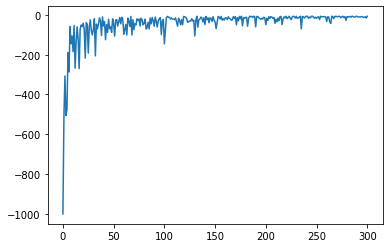

In [54]:
### 0.2 alpha, 0.05 epsilon
reward_performance_perepisode(env=gym.make('KingWindyGridWorld-v0'),alpha=0.2,epsilon=0.05,qfunction=SarsaAgent)

In [55]:
path(env=gym.make('KingWindyGridWorld-v0'))

############
#          #
#          #
#X         #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#SX     G  #
#          #
#          #
#          #
############

############
#          #
#          #
#  X       #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#  X       #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#  X       #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
# X        #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S  

## Stochastic King Gridworld

### With Qlearning


∈ = 0.25 , α = 0.5 , mean reward = -58.0


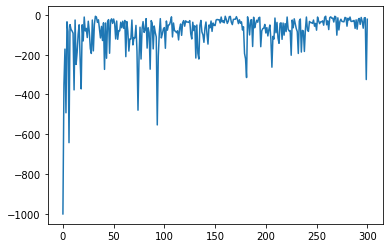

In [56]:
### 0.5 alpha, 0.25 epsilon
reward_performance_perepisode(env=gym.make('StochKingWindyGridWorld-v0'),alpha=0.5,epsilon=0.25,qfunction=QLearningAgent)

In [57]:
path(env=gym.make('StochKingWindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
#      X   #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#        X #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#         X#
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#         X#
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#        X #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#    

In [58]:
# 0.5 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('StochKingWindyGridWorld-v0'),alpha=0.5,epsilon=0.1,qfunction=QLearningAgent)

∈ = 0.1 , α = 0.5 , mean reward = -39.8


In [59]:
path(env=gym.make('StochKingWindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
#          #
#         X#
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#        X #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#        X #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#        X #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#        X #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#         X#
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#         X#
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#         X#
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#    

∈ = 0.1 , α = 0.25 , mean reward = -20.8


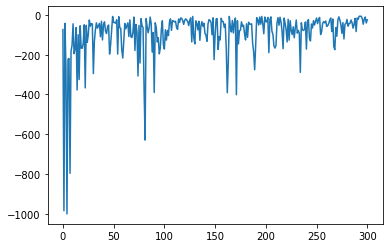

In [60]:
### 0.25 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('StochKingWindyGridWorld-v0'),alpha=0.25,epsilon=0.1,qfunction=QLearningAgent)

In [61]:
path(env=gym.make('StochKingWindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
#         X#
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#        X #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#         X#
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#         X#
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#         X#
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#        X #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#        X #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#    

### With SARSA


∈ = 0.1 , α = 0.5 , mean reward = -16.3


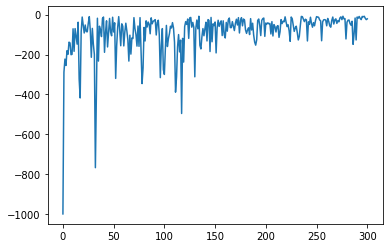

In [62]:
### 0.5 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('StochKingWindyGridWorld-v0'),alpha=0.5,epsilon=0.1,qfunction=SarsaAgent)

In [63]:
path(env=gym.make('StochKingWindyGridWorld-v0'))

############
#          #
#          #
#          #
#S      G  #
# X        #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#  X       #
#          #
############

############
#          #
#          #
#          #
#S      G  #
# X        #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
# X        #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#  X       #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#   X      #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#  X       #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#          #
# X        #
############

############
#          #
#          #
#          #
#S  

In [64]:
### 0.5 alpha, 0.25 epsilon
reward_performance_perepisode(env=gym.make('StochKingWindyGridWorld-v0'),alpha=0.5,epsilon=0.25,qfunction=SarsaAgent)

∈ = 0.25 , α = 0.5 , mean reward = -56.4


In [65]:
path(env=gym.make('StochKingWindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
#          #
#          #
# X        #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#SX     G  #
#          #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#X         #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
# X        #
#          #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#  X       #
#          #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#          #
#  X       #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#          #
#   X      #
############

############
#          #
#          #
#          #
#S      G  #
#          #
#  X       #
#          #
############

############
#    

In [66]:
### 0.1 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('StochKingWindyGridWorld-v0'),alpha=0.1,epsilon=0.1,qfunction=SarsaAgent)

∈ = 0.1 , α = 0.1 , mean reward = -76.9


In [67]:
path(env=gym.make('StochKingWindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
#          #
# X        #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#X         #
#          #
#S      G  #
#          #
#          #
#          #
############

############
# X        #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
# X        #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#          #
#  X       #
#S      G  #
#          #
#          #
#          #
############

############
#          #
# X        #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#    

∈ = 0.1 , α = 0.25 , mean reward = -40.5


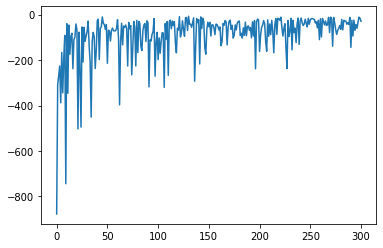

In [68]:
### 0.25 alpha, 0.1 epsilon
reward_performance_perepisode(env=gym.make('StochKingWindyGridWorld-v0'),alpha=0.25,epsilon=0.1,qfunction=SarsaAgent)

In [69]:
path(env=gym.make('StochKingWindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
# X        #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
#X         #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#X         #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#          #
# X        #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#  X 

∈ = 0.05 , α = 0.2 , mean reward = -49.8


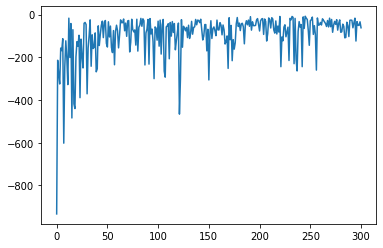

In [70]:
### 0.2 alpha, 0.05 epsilon
reward_performance_perepisode(env=gym.make('StochKingWindyGridWorld-v0'),alpha=0.2,epsilon=0.05,qfunction=SarsaAgent)

In [71]:
path(env=gym.make('StochKingWindyGridWorld-v0'))

Streaming output truncated to the last 5000 lines.
#      X   #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#      X   #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#      X   #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#       X  #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#      X   #
#          #
#          #
#S      G  #
#          #
#          #
#          #
############

############
#    

## Compare performance of Sarsa vs. Q-Learning under the same alpha and epsilon

In [72]:
from IPython.display import clear_output
from pandas import DataFrame
env=gym.make('WindyGridWorld-v0')
n_actions = env.action_space.n
env.reset()
done = False
while not done:
   action = env.action_space.sample()
   state, reward, done, info = env.step(action)
agent_sarsa = SarsaAgent(alpha=0.5, epsilon=0.1, discount=1,
                  get_legal_actions=lambda s: range(n_actions))

agent_ql=QLearningAgent(alpha=0.5, epsilon=0.1, discount=1,
                  get_legal_actions=lambda s: range(n_actions))

def moving_average(x, span=100): return DataFrame(
    {'x': np.asarray(x)}).x.ewm(span=span).mean().values


rewards_sarsa, rewards_ql = [], []

for i in range(151):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 50 == 0:
        clear_output(True)
        print('SARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.xlabel("Number of episodes")
        plt.ylabel("Rewards")
        plt.ylim(-500, 0)
        plt.show()


SARSA mean reward = -28.06
QLEARNING mean reward = -25.52


### Learning rate is very large for SARSA, let's decrease it to 0.1 and see what will happen.

### In this way SARSA is learning slowly, but we give agent chance to find better policy.

### Both are different because Q-Learning takes the max over next action values. So it only changes when the agent learns that one action is better than another. In contrast, SARSA uses the estimate of the next action value in its target. This changes every time the agent takes an exploratory action.

## Change in alpha value

SARSA mean reward = -31.34
QLEARNING mean reward = -17.13


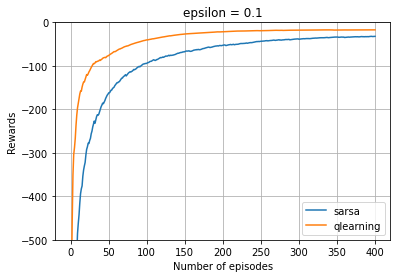

In [73]:
from IPython.display import clear_output
from pandas import DataFrame
env=gym.make('WindyGridWorld-v0')
n_actions = env.action_space.n
env.reset()
done = False
while not done:
   action = env.action_space.sample()
   state, reward, done, info = env.step(action)
agent_sarsa = SarsaAgent(alpha=0.1, epsilon=0.1, discount=1,
                  get_legal_actions=lambda s: range(n_actions))

agent_ql=QLearningAgent(alpha=0.5, epsilon=0.1, discount=1,
                  get_legal_actions=lambda s: range(n_actions))

def moving_average(x, span=100): return DataFrame(
    {'x': np.asarray(x)}).x.ewm(span=span).mean().values


rewards_sarsa, rewards_ql = [], []

for i in range(401):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 100 == 0:
        clear_output(True)
        print('SARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.xlabel("Number of episodes")
        plt.ylabel("Rewards")
        plt.ylim(-500, 0)
        plt.show()


### SARSA learns the same final policy as Q-Learning, but more slowly. We know both algorithms have to converged to the same policy because the slopes of the lines are equal. Equal slopes mean that both agents are completing episodes at the same rate. 

## Optimal solution
### Evaluated by number of episodes and avg rewards.

### At windy gridword
#### Qlearning: alpha=0.5, epsilon=0.1
#### SARSA: alpha=0.5, epsilon=0.1

### At stochastic windy gridword
#### Qlearning: alpha=0.25, epsilon=0.1
#### SARSA: alpha=0.1, epsilon=0.1

### At king windy gridword
#### Qlearning: alpha=0.25, epsilon=0.1
#### SARSA: alpha=0.5, epsilon=0.1

### At stochastic king windy gridword
#### Qlearning: alpha=0.5, epsilon=0.1
#### SARSA: alpha=0.5, epsilon=0.1

## Reference
https://www.kaggle.com/code/kamal007/windy-grid-world-solution-using-sarsa-q-learning#3.1-Experiment-Observations-for-SARSA,-%E2%88%88=0.1,%CE%B1=0.5

https://github.com/ibrahim-elshar/gym-windy-gridworlds